In [3]:
# Importing the Necessary Libraries

import pandas as pd
from pandas import Series as Series
import numpy as np
import matplotlib.pyplot as plt  


# %matplotlib inline

**Getting the data**

In [4]:
nifty50_df = pd.read_csv('../datasets/inidices/NIFTY 50.csv')
nifty50_df['Date'] = pd.to_datetime(nifty50_df.Date,format='%Y-%m-%d')
nifty50_df =nifty50_df.sort_values('Date')
nifty50_df_date = nifty50_df.set_index('Date')


nifty50_df.columns, nifty50_df.shape

(Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Turnover'], dtype='object'),
 (7510, 7))

In [5]:
nifty50_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7510 entries, 0 to 7509
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      7510 non-null   datetime64[ns]
 1   Open      7510 non-null   float64       
 2   High      7510 non-null   float64       
 3   Low       7510 non-null   float64       
 4   Close     7510 non-null   float64       
 5   Volume    6097 non-null   float64       
 6   Turnover  6097 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 469.4 KB


In [6]:
start = nifty50_df[nifty50_df['Date']=='2005-01-03'].index[0]
nifty50_df = nifty50_df[start:]

nifty50_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4092 entries, 3418 to 7509
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      4092 non-null   datetime64[ns]
 1   Open      4092 non-null   float64       
 2   High      4092 non-null   float64       
 3   Low       4092 non-null   float64       
 4   Close     4092 non-null   float64       
 5   Volume    4092 non-null   float64       
 6   Turnover  4092 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 255.8 KB


In [7]:
nifty50_df_date = nifty50_df_date[start:]
nifty50_df_date.shape

(4092, 6)

#### 80-20 split-  3200 , 892

In [8]:
df_train = nifty50_df_date.iloc[:3200,:]
df_test = nifty50_df_date.iloc[3200:,:]

df_test.shape, df_train.shape

((892, 6), (3200, 6))

# **Time Series**
#### **We now use the time series models like ARMA, ARIMA and SARIMA to predict the Closing prices.**
#### **Here is the plot of the time series data for all the variables**


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

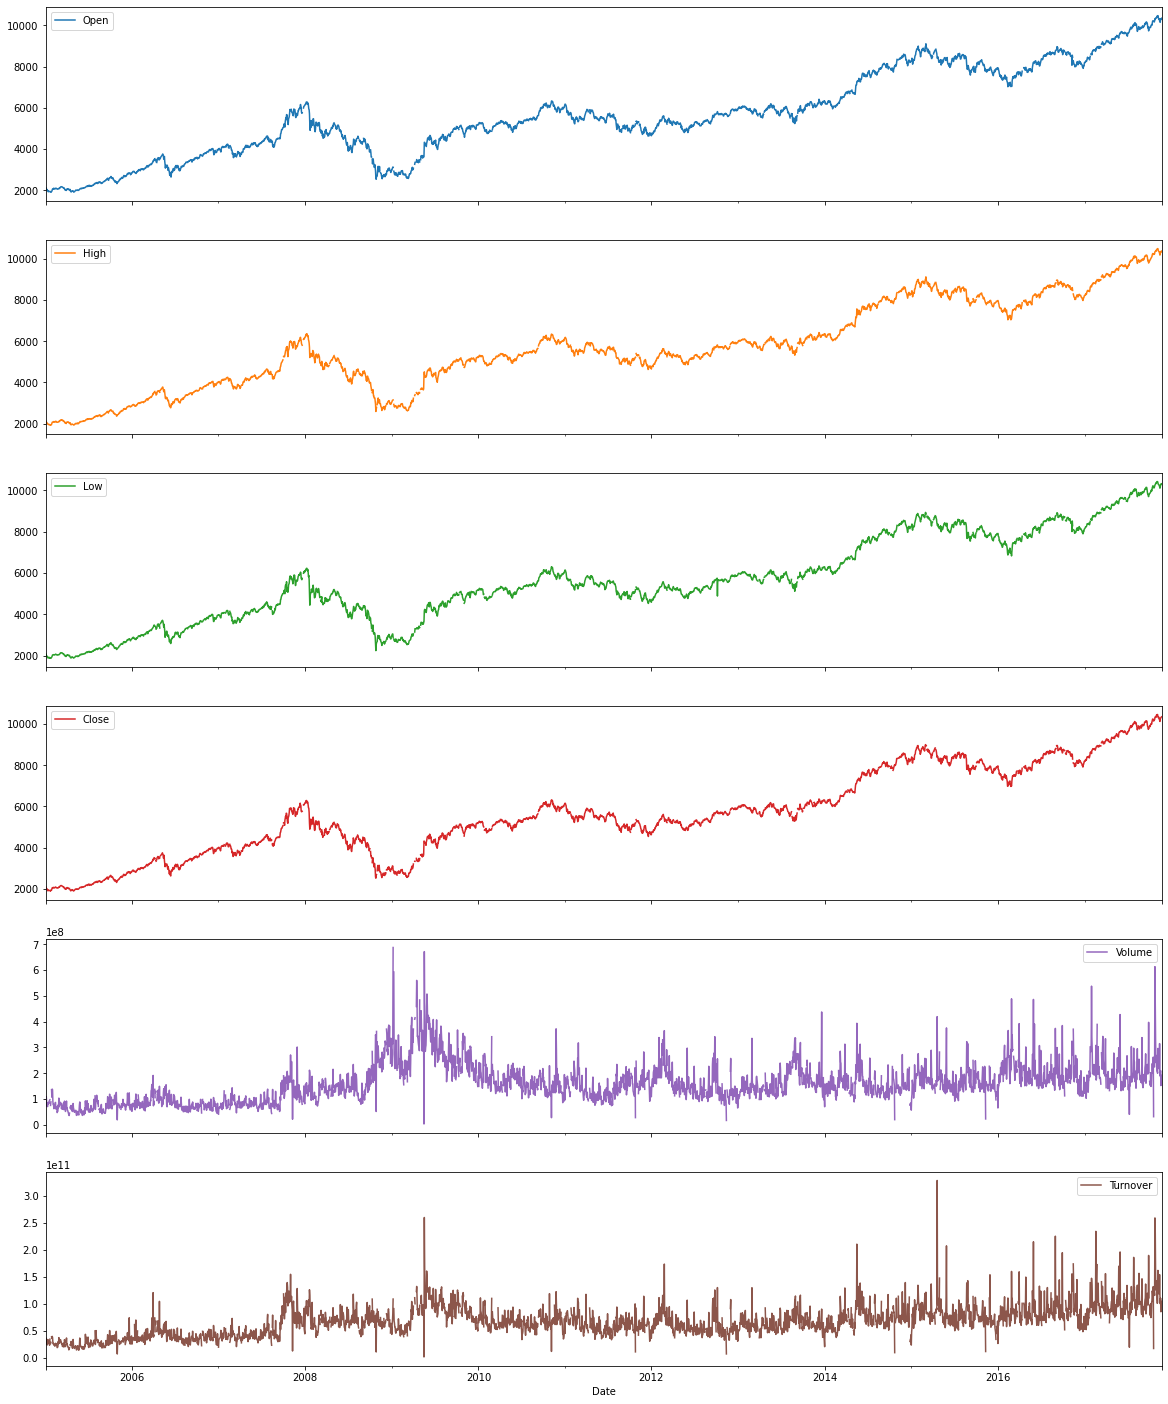

In [9]:
df_train.asfreq('B').plot(subplots=True, figsize=(20,25))

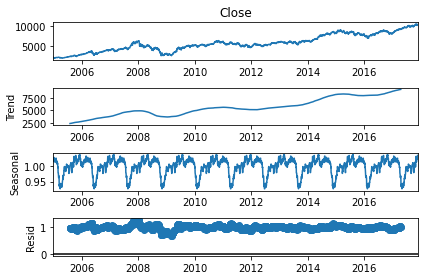

In [10]:
import statsmodels.api as sm

decomposed_a = sm.tsa.seasonal_decompose(df_train["Close"],period=300,model="multiplicative") # The frequncy is annual
figure = decomposed_a.plot()
plt.show()

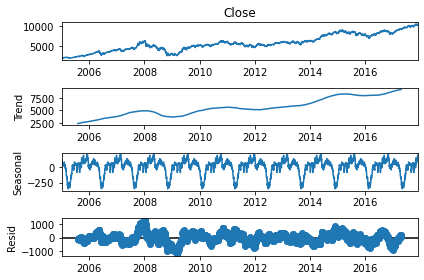

In [11]:
decomposed_a = sm.tsa.seasonal_decompose(df_train["Close"],period=300,model="additive") # The frequncy is annual
figure = decomposed_a.plot()
plt.show()

#### **As the Residuals and Seasonality is independent of the Trend, the data is additive.**
####  with a trend and seasonal component

### **Test for Stationarity**

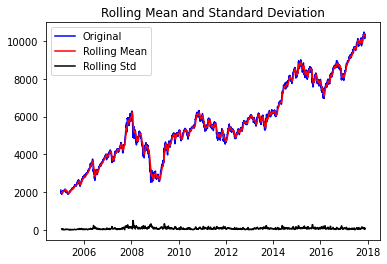

In [12]:
#Determing rolling statistics
rolmean = df_train.Close.rolling(12).mean()
rolstd = df_train.Close.rolling(12).std()
#Plot rolling statistics:
plt.plot(df_train.Close, color='blue',label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation')
plt.show(block=False)

#### **After analysing the above graph, we can see the increasing mean and standard deviation and hence our series is not stationary.**

In [13]:
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic

def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    test = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [14]:
test_stationarity(df_train['Close'])

Results of Dickey-Fuller Test:
Test Statistic                   -0.482236
p-value                           0.895437
#Lags Used                        1.000000
Number of Observations Used    3198.000000
Critical Value (1%)              -3.432396
Critical Value (5%)              -2.862444
Critical Value (10%)             -2.567251
dtype: float64


#### **Ho: It is non-stationary**

#### **H1: It is stationary**

#### **We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary. Hence we stationarise the data.**

[]

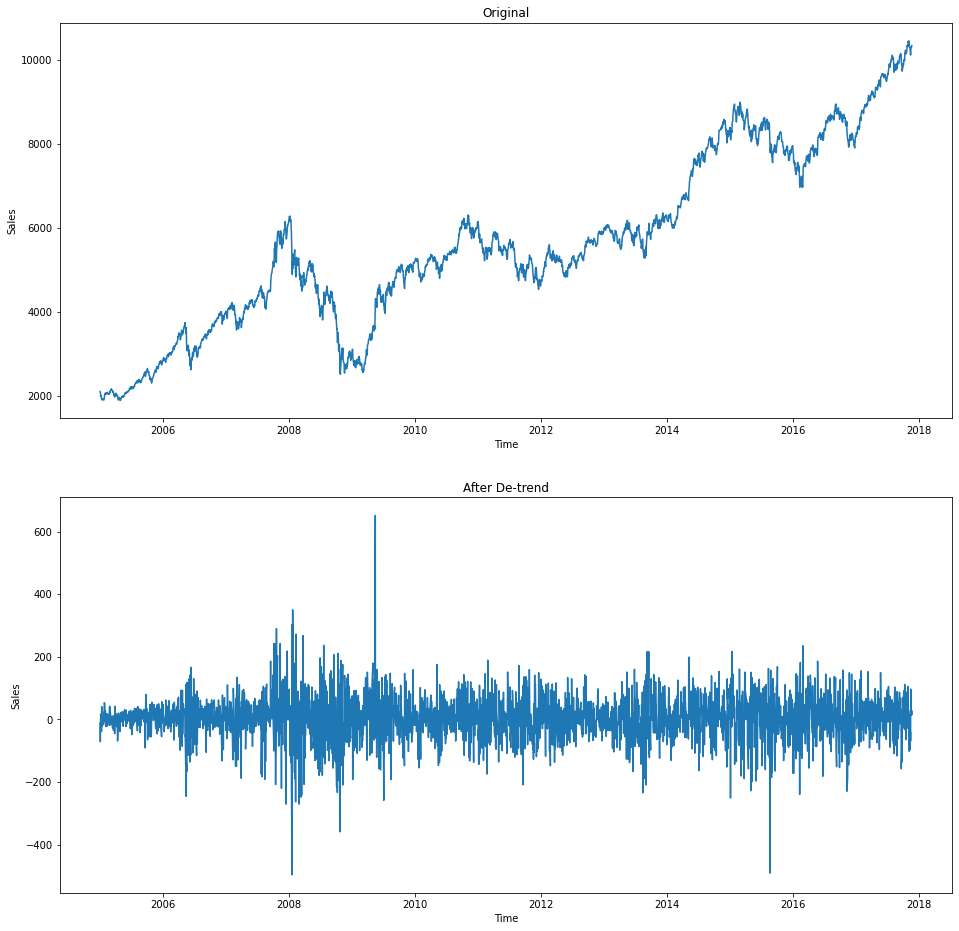

In [15]:
ts=df_train.groupby(["Date"])["Close"].sum()        ## aggregate duplicates
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(211)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(212)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts = ts.diff(periods=1).dropna()

plt.plot(new_ts)
plt.plot()

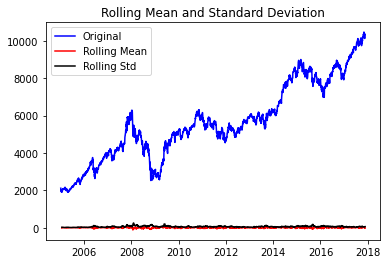

In [16]:
#Determing rolling statistics
rolmean = new_ts.rolling(12).mean()
rolstd = new_ts.rolling(12).std()
#Plot rolling statistics:
plt.plot(df_train.Close, color='blue',label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation')
plt.show(block=False)

In [17]:
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                  -22.021223
p-value                           0.000000
#Lags Used                        6.000000
Number of Observations Used    3192.000000
Critical Value (1%)              -3.432400
Critical Value (5%)              -2.862446
Critical Value (10%)             -2.567252
dtype: float64


#### **Ho: It is non-stationary**

#### **H1: It is stationary**

#### **We see that the p-value is less than 0.05 so we reject the Null hypothesis. So the data is stationary.**

#### **The data after First Order Differencing is stationarised and is thus verified using the Rolling Statistics and the Augmented Dickey-Fuller Test.**

<Figure size 1152x1152 with 0 Axes>

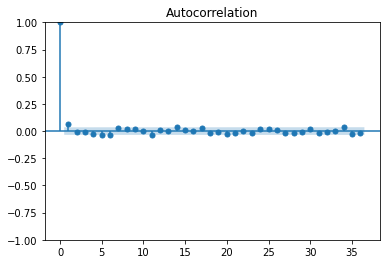

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(16,16))
plot_acf(new_ts)
plt.show()

C:\Users\gaura\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


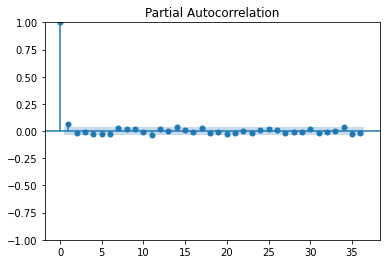

In [19]:
plot_pacf(new_ts)
plt.show()

#### **From the above plots, it can be seen that the data after de-trending as a lag of 1 in both the ACF and PACF.**

In [20]:
from pmdarima.arima.utils import ndiffs

ndiffs(ts.values, test='adf')

1

We can see that First Order differencing removes the trend and stationarises the data and this is confirmed using the ndiffs() from the pmdarima which gives the order of differencing.

### **SARIMA Model**

#### **SARMIA model internally handles all the required tasks like de-seasonalization, de-trending, etc**

In [ ]:
# statistical way to find seasonal index

from scipy.stats import kruskal

def seasonality_test(series, index):
        seasoanl = False
        idx = np.arange(len(series.index)) % index
        H_statistic, p_value = kruskal(series, idx)
        if p_value <= 0.05:
            seasonal = True
        return seasonal,p_value

'''
for i in range(5,300):      # check 5 day seasonality to 300 days
    print(i,seasonality_test(df_train['Close'],i))
'''
seasonality_test(df_train['Close'],16)

(True, 0.0)

In [30]:
import pmdarima as pm

train_data_sarima = df_train['Close']
test_data_sarima = df_test['Close']

sarima_model = pm.auto_arima(train_data_sarima,
                           start_p=1, start_q=0,
                           test='adf',
                           max_p=2, max_q=2, m=16,
                           start_P=0,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,
                           random = True)

sarima_model.summary()


Performing stepwise search to minimize aic
 ARIMA(1,0,0)(0,1,1)[16] intercept   : AIC=inf, Time=15.70 sec
 ARIMA(0,0,0)(0,1,0)[16] intercept   : AIC=44977.483, Time=0.23 sec
 ARIMA(1,0,0)(1,1,0)[16] intercept   : AIC=37341.466, Time=12.91 sec
 ARIMA(0,0,1)(0,1,1)[16] intercept   : AIC=41848.140, Time=16.48 sec
 ARIMA(0,0,0)(0,1,0)[16]             : AIC=45044.884, Time=0.18 sec
 ARIMA(1,0,0)(0,1,0)[16] intercept   : AIC=38200.302, Time=1.65 sec
 ARIMA(1,0,0)(2,1,0)[16] intercept   : AIC=36975.346, Time=71.99 sec
 ARIMA(1,0,0)(2,1,1)[16] intercept   : AIC=inf, Time=64.24 sec
 ARIMA(1,0,0)(1,1,1)[16] intercept   : AIC=inf, Time=15.64 sec
 ARIMA(0,0,0)(2,1,0)[16] intercept   : AIC=44978.057, Time=9.57 sec


In [ ]:
import sklearn.metrics as sme
import math

yPredS = sarima_model.predict(n_periods = len(test_data_sarima))

rmse = math.sqrt(sme.mean_squared_error(test_data_sarima, yPredS ))
print("The root mean squared error is {}.".format(rmse))
